# 運用への適用事例: Webサービスのログ解析


計算機インフラの御守では種々雑多なドキュメンテーションが不可欠です。日々の作業で証跡を残す、手順を整理して共有・再利用する、ユーザマニュアルや教材を整備する.. 国立情報学研究所（NII）のクラウド運用担当では、これらをシームレスに記述・蓄積する方法を研究しています。
<img src="./images/literate_computing-logo.png" align="center" />

プロジェクトでは [Jupyter Notebook]( http://jupyter.org ) を用いてドキュメンテーションを行うことで、運用作業の信頼性向上、手順やノウハウの蓄積・流通が容易になることを目指しています。

---
ここではログを解析する手順・ノウハウをNotebokで記述した例を紹介します。

# ログファイルの取得

この事例ではみなさんがアクセスしているWebサービスのアクセスログを題材にします。
サービスをホスティングしている環境（JupyterHub）からログをダウンロードします。

> **まとめ実行機能** <br>
> 表題の左側にある <span class='fa fa-fw fa-caret-right' style='color:#a0a0a0;'></span> は、詳細な手順が畳み込まれていることを示しています。  <span class='fa fa-fw fa-caret-right' style='color:#a0a0a0;'></span>  をクリックすると、 <span class='fa fa-fw fa-caret-down' style='color:#a0a0a0;'></span>  に変化し、畳み込まれている内容を表示することができます。
>
> <img src="./images/run_through.png" align="right" width=30% /> 畳みこまれている内容に「手順」が含まれていると、右のように表示されます。<span class='fa fa-fw fa-square' style='color:#cccccc;'></span>の数は畳み込まれている手順のステップ数を示しています。
> 表示から <span class='fa fa-fw fa-play-circle'></span> を押すと、配下の手順をまとめて実行することができます。
>
> <img src="./images/run_through_OK.png" width=30% align=right /> すべてのステップが終了すると右のように表示が変化します。実行が完了したステップは薄緑 <span class='fa fa-fw fa-square' style='color:#88ff88;'></span>に表示されます。また、完了したステップは、再度 まとめ実行ボタン<span class='fa fa-fw fa-play-circle'></span>をクリックしても実行されないようロック<span class='fa fa-fw fa-lock'></span>されます。
>
> <img src="./images/run_through_NG.png" width=30% align=right /> 途中でエラーが発生した場合は当該のステップが薄紅<span class='fa fa-fw fa-square' style='color:#ff8888;'></span>に表示されるので、 (<span class='fa fa-fw fa-caret-right'></span>)をクリックして内容を確認します。

---

*<span class='fa fa-fw fa-play-circle'></span> をクリックすると一連の手順をまとめて実行できます。*
*表題左側の <span class='fa fa-fw fa-caret-right' style='color:#a0a0a0;'></span> をクリックすると畳み込まれている手順を確認できます。*

ダウンロード先の一時ファイルをダウンロードするディレクトリを作成します。

In [ ]:
import tempfile
import os
work_dir = tempfile.mkdtemp() # テンポラリのディレクトリを作成
notebook_dir = os.getcwd()

print(work_dir, notebook_dir)

ファイルをダウンロードします。

In [ ]:
!cd {work_dir} && tar zxvf {notebook_dir}/resources/access-anonymous.log.tar.gz && cd {notebook_dir}; \
ls -latr {work_dir}/

# Nginx のログを解析する

このWebサービスは Nginx を用いています。 先に取得したログを可視化してみましょう。
以下の手順は [By Jess Johnson (http://grokcode.com)](http://grokcode.com) を参考にしています。

以下の手順で、前節で読み込んだログファイルをパースして[PandasのDataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)に変換します。

---

*<span class='fa fa-fw fa-play-circle'></span> をクリックすると一連の手順をまとめて実行できます。*
*表題左側の <span class='fa fa-fw fa-caret-right' style='color:#a0a0a0;'></span> をクリックすると畳み込まれている手順を確認できます。*

## Setup

In [ ]:
%pylab inline

Let's import the usual suspects. 

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

We will also use [apachelog](https://code.google.com/p/apachelog/), which is a module for parsing apache logs, but it works fine with nginx logs as long as we give it the right format string. You can install it with `pip install apachelog`.  

In [ ]:
import apachelog

## Parsing the log

I started out by doing some command line preprocessing on the log in order to remove bots. I used `egrep -v` to filter out the bots that were hitting the site the most often. These were Googlebot, Bingbot, the New Relic uptime checker, Buidu spider, and a few others. A more careful approach would filter out everything on one of the known bot lists ([like this one](http://www.robotstxt.org/db.html)), but I'm going to play it a bit fast and loose.

First of all let's get a sample line out of the `access.log` and try to parse it. Here is a description of the codes in the log format we are working with:

    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    %i      - Referer is the page that linked to this URL.
    User-agent  - the browser identification string
    %V          - the server name according to the UseCanonicalName setting

In [ ]:
sample_string = '178.137.91.215 - - [21/Feb/2014:06:44:53 +0000] "GET /work/homepages-maths-year-6/ HTTP/1.0" \
200 10427 "http://authoralcove.com/work/homepages-maths-year-6/" "Opera/9.80 (Windows NT 6.1; WOW64; U; ru) \
Presto/2.10.289 Version/12.00" "-"'
nformat = r'%h %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" \"%V\"'
p = apachelog.parser(nformat)
data = p.parse(sample_string)
data

Now let's parse each line while preparing the access time so that pandas will be able to handle it.

In [ ]:
import os
from apachelog import ApacheLogParserError
log_list = []
log_dir = work_dir
log_file = 'access-anonymous.log'

with open(os.path.join(log_dir, log_file)) as f:
    for line in f.readlines():
        data = p.parse(line)
        data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21]+' '+data['%t'][22:27]
        log_list.append(data)

Loading into pandas.

In [ ]:
from pandas import Series, DataFrame, Panel
df = DataFrame(log_list)
df[0:3] 

Now lets clean up the pandas dataframe a bit by deleting some columns we aren't interested in and renaming the remaining columns.

In [ ]:
del df['%V']
del df['%h']
del df['%i']
del df['%l']
del df['%u']
del df['%{User-Agent}i']
df[0:5]

In [ ]:
df = df.rename(columns={'%>s': 'Status', '%b':'b', 
                        '%r':'Request', '%t': 'Time'})
df[0:2]

Massage the data a bit more so that the access time is a `datetime`, status is an `int`, and the response size is in MB, with missing data represented as `NaN`, not `-`.

In [ ]:
df.index = pd.to_datetime(df.pop('Time'))

In [ ]:
df['Status'] = df['Status'].astype('int')

In [ ]:
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = float(x)/1048576.
    
    return x
df['b'] = df['b'].apply(dash2nan)

In [ ]:
df[0:2]

# 解析結果を可視化する

以下のセルでは以前の実行結果を残してあります。 ここまでのステップを実行した後で実行すると、内容がアップデートされます。

First let's increase the graph size.

In [15]:
from pylab import *
rcParams['figure.figsize'] = 10, 5 # width, height in inches

Now let's graph the requests hitting the web server. `10t` will use a 10 minute interval size, so each point on the graph shows the number of requestes in a 10 minute window.

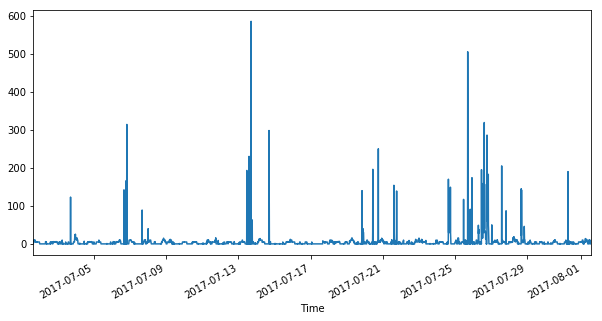

In [16]:
df_s = df['Status'].resample('10t').count()
df_s.plot()


Let's see how the server held up by looking at some response codes.

In [17]:
df['Status'].value_counts()

405    10830
200     6756
304     3367
302      698
400      295
101      160
404      110
201      108
502       41
204       26
504       14
499        8
Name: Status, dtype: int64

500番台のエラーコード、499, 444 が出力される場合は注意

There are quite a few 500 errors here. 499 errors are also bad news because it means that the client closed the connection before the page could be served. These are almost certainly because the site wasn't responding in a reasonable timeframe.

Let's graph the response codes.

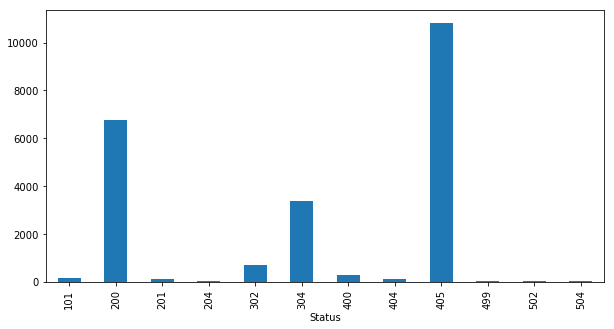

In [18]:
grouped_status = df.groupby('Status')
grouped_status.size().plot(kind='bar')

OK that doesn't look too bad. The vast majority of requests were served a 200 (OK) response.

Let's graph the most common response codes over time, with a sample timespan of 1 hour.

In [19]:
t_span = '60t'
df_200 = df['Status'][df['Status'] == 200].resample(t_span).count()
df_502 = df['Status'][df['Status'] == 502].resample(t_span).count()
df_499 = df['Status'][df['Status'] == 499].resample(t_span).count()
df_304 = df['Status'][df['Status'] == 304].resample(t_span).count()
df_302 = df['Status'][df['Status'] == 302].resample(t_span).count()
df_404 = df['Status'][df['Status'] == 404].resample(t_span).count()
df_504 = df['Status'][df['Status'] == 504].resample(t_span).count()
df_301 = df['Status'][df['Status'] == 301].resample(t_span).count()

status_df = DataFrame({'OK': df_200, 
                       'Bad Gateway': df_502, 
                       'Client Closed': df_499, 
                       'Not Modified': df_304, 
                       'Found': df_302, 
                       'Not Found': df_404,
                       'Gateway Timeout': df_504,
                       'Moved Permenantely': df_301})

In [20]:
status_df.fillna(0, inplace=True)
status_df[0:5]

,OK,Bad Gateway,Client Closed,Not Modified,Found,Not Found,Gateway Timeout,Moved Permenantely
Time,,,,,,,,
2017-07-01 17:00:00+09:00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0
2017-07-01 18:00:00+09:00,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0
2017-07-01 19:00:00+09:00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0
2017-07-01 20:00:00+09:00,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0
2017-07-01 21:00:00+09:00,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0


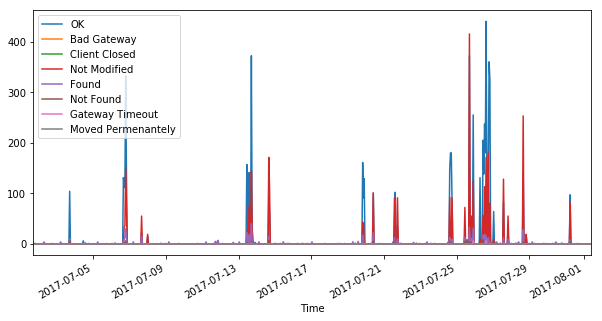

In [21]:
status_df.plot()
legend()

ブラウザのキャッシュがどれぐらい有効か集計してみる。

    200    Success    OK 
    206    Success    Partial content
    304    Cache      Not modified
    302    Success    Found
    301    Success    Moved permanently
    400    Failure    Bad request
    401    Failure    Unauthorized
    403    Failure    Forbidden
    404    Failure    Not Found
    405    Failure    Method not allowed
    408    Failure    Request timeout
    444    Failure    No response
    499    Failure    Client closed request
    502    Failure    Bad Gateway
    504    Failure    Gateway timeout
    500    Failure    Internal server error


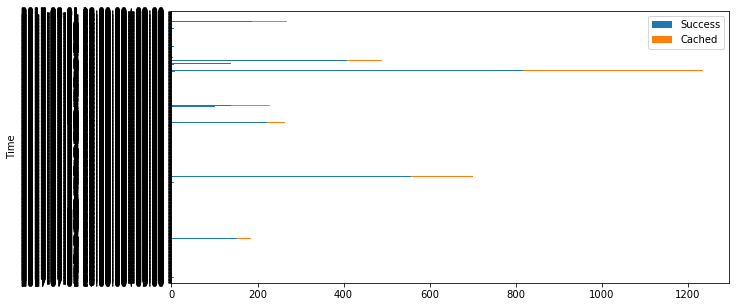

In [22]:
success_df = df['Status'][df['Status'].isin([200, 206, 304, 302, 301])].resample(t_span).count()
fail_df = df['Status'][df['Status'].isin([400, 401, 403, 404, 405, 444, 499, 502, 504, 500])].resample(t_span).count()
cache_df =df['Status'][df['Status'].isin([304])].resample(t_span).count()
statusx_df = DataFrame({'Success': success_df, 'Cached': cache_df}) 
statusx_df.plot.barh(stacked=True)
legend()


静的なコンテンツ等を除いたアクセスランキング

# 参考資料
* https://github.com/grokcode/ipython-notebooks (MIT License)